# This notebook focuses on the idea of a one-stop shop for time series analysis:
in the last few years, several packages have appeared that position themselves in such a fashion. We will take them for a test drive and have a look at how close they come to fulfilling the promise. Each of the packages implementing the "automatic for the people" philosophy for time series, and as such has it own dedicated section below:

* [AutoTS](#section-one)
* [Darts](#section-two)
* [Kats](#section-three)
* [Bonus track: GluonTS](#section-four) 

Disclaimer: since the packages we use are somewhat experimental, we will need to install each of them separately in their respective sections.

In [2]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

from autots.models.model_list import model_lists
from autots import AutoTS

from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionEnsembleModel, RegressionModel
from darts.metrics import rmse
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
import darts.metrics as dme
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset
from darts.models import NaiveSeasonal, NaiveDrift

from functools import reduce

In [3]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category= FutureWarning)

# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    #  for faster iteration / execution
    cutoff = '2018-01-01'        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

In [4]:
# helper functions
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x, y)), 4)

For the sake of a meaningful comparison, we will stick to the same dataset across different models and revisit the Nifty-50 data we used in the ARIMA episode


<AxesSubplot:>

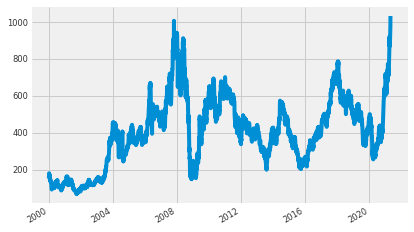

In [5]:
stock_name = 'TATASTEEL'
# load the data
df = pd.read_csv(f'data/nifty_50_stock_market_data_2000_2020/{stock_name}.csv', usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [6]:
# split into training / validation
df_train, df_test = df.iloc[df.index <= '2021-01-01'], df.iloc[df.index > '2021-01-01']
print(df_train.shape, df_test.shape)

(5227, 1) (79, 1)


<a id="section-one"></a>
# AutoTS


Auto-TS is the closest we have in applying the AutoML philosophy specifically to time series. Primary features include:

* finding an optimal time series forecasting model using genetic programming optimization
* training diverse models
* data transformations 
* combination of metrics for model selection

In [7]:
# !pip install autots

First thing we do: which models are available to play with? The possible candidate models are grouped into several (overlapping!) classes:

In [8]:
model_lists.keys()

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs'])

In [9]:
# full list of models:
model_lists['all']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'GLM',
 'ETS',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'GluonTS',
 'SeasonalNaive',
 'UnobservedComponents',
 'VARMAX',
 'VECM',
 'DynamicFactor',
 'MotifSimulation',
 'WindowRegression',
 'VAR',
 'TFPRegression',
 'ComponentAnalysis',
 'DatepartRegression',
 'UnivariateRegression',
 'Greykite',
 'UnivariateMotif',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'Theta',
 'ARDL',
 'NeuralProphet',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH']

In [10]:
model_lists['fast']

{'ConstantNaive': 1,
 'LastValueNaive': 1.5,
 'AverageValueNaive': 1,
 'GLS': 1,
 'SeasonalNaive': 1,
 'GLM': 1,
 'ETS': 1,
 'VAR': 0.8,
 'VECM': 1,
 'WindowRegression': 0.5,
 'DatepartRegression': 0.8,
 'UnivariateMotif': 1,
 'MultivariateMotif': 0.8,
 'SectionalMotif': 1,
 'NVAR': 1}

In [11]:
model_lists['superfast']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'SeasonalNaive']

In [12]:
model_lists['probabilistic']

['ARIMA',
 'GluonTS',
 'FBProphet',
 'AverageValueNaive',
 'VARMAX',
 'DynamicFactor',
 'VAR',
 'UnivariateMotif',
 'MultivariateMotif',
 'SectionalMotif',
 'NVAR',
 'Theta',
 'ARDL',
 'UnobservedComponents',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH']

There are quite a few models to choose from (most of which weren't discussed before), but we focus on one: 
- the Theta method was proposed in 2000: https://www.researchgate.net/publication/223049702_The_theta_model_A_decomposition_approach_to_forecasting
- regression on time + exponential smoothing
- degrees of damping the trend via $\theta$
- de/reseasonalize


OLS: 

\begin{equation}
    X_t = a_0 + b_0 (t-1) + \epsilon_t 
\end{equation}


SES:
\begin{equation}
S_t = (1 - \alpha) X_t + \alpha S_{t-1}
\end{equation}


Forecast:
\begin{equation}
\hat{X}_{T+h|T} = \frac{\theta - 1}{\theta} b_0 \left[h - 1 + \frac{1}{\alpha} - \frac{(1 - \alpha)^T}{\alpha} \right] + S_{T+h | T}
\end{equation}


Specify the model parameters:

In [13]:
# specify the model
model = AutoTS(
    forecast_length=len(df_test),
    frequency='infer',
    prediction_interval=0.9,
    ensemble= 'simple',  # select single best model
    # we want some results, but also execution in reasonable time
    # GA ARE SLOW
    model_list =  ['GLM', 'Theta', 'ETS'], 
    transformer_list="superfast",  
    drop_most_recent=1,
    max_generations=5,
    num_validations=2,
    validation_method="backwards"
)

# fit the model
model = model.fit(
    df_train,
#     date_col= None, # 'datetime' if long else None,
#     value_col= None,#  'value' if long else None,
#     id_col= None,   #'series_id' if long else None,
)

Inferred frequency is: B
Model Number: 1 with model ETS in generation 0 of 5
Model Number: 2 with model ETS in generation 0 of 5
Model Number: 3 with model GLM in generation 0 of 5
Template Eval Error: TypeError("ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''") in model 3: GLM
Model Number: 4 with model GLM in generation 0 of 5
Model Number: 5 with model ETS in generation 0 of 5
Model Number: 6 with model Theta in generation 0 of 5
Model Number: 7 with model GLM in generation 0 of 5
Model Number: 8 with model Theta in generation 0 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1342: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


Model Number: 9 with model ETS in generation 0 of 5
Model Number: 10 with model GLM in generation 0 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 11 with model GLM in generation 0 of 5
Template Eval Error: TypeError("ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''") in model 11: GLM
Model Number: 12 with model GLM in generation 0 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 12: GLM
Model Number: 13 with model ETS in generation 0 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 14 with model GLM in generation 0 of 5
Template Eval Error: TypeError("ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''") in model 14: GLM
Model Number: 15 with model ETS in generation 0 of 5
Model Number: 16 with model GLM in generation 0 of 5
Model Number: 17 with model ETS in generation 0 of 5
Model Number: 18 with model GLM in generation 0 of 5
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 18: GLM
Model Number: 19 with model GLM in generation 0 of 5
Model Number: 20 with model ETS in generation 0 of 5
Model Number: 21 with model Theta in generation 0 of 5
New Generation: 1 of 5
Model Number: 22 with model ETS in generation 1 of 5
Model Number: 23 with model ETS in generation 1 of 5
Model Number: 24 with model Theta in generation 1 of 5
Model Number: 25 with model Theta in generation 1 of 5
Model Number: 26 with m

/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 31 with model ETS in generation 1 of 5
Model Number: 32 with model ETS in generation 1 of 5
Model Number: 33 with model Theta in generation 1 of 5
Model Number: 34 with model ETS in generation 1 of 5
Model Number: 35 with model Theta in generation 1 of 5
Model Number: 36 with model ETS in generation 1 of 5
New Generation: 2 of 5
Model Number: 37 with model ETS in generation 2 of 5
Model Number: 38 with model ETS in generation 2 of 5
Model Number: 39 with model ETS in generation 2 of 5
Model Number: 40 with model Theta in generation 2 of 5
Model Number: 41 with model ETS in generation 2 of 5
Model Number: 42 with model ETS in generation 2 of 5
Model Number: 43 with model ETS in generation 2 of 5
Model Number: 44 with model GLM in generation 2 of 5
Model Number: 45 with model Theta in generation 2 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1342: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13766D+00    |proj g|=  3.36631D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     23      1     0     0   1.656D-02  -3.138D+00
  F =  -3.1379741973938065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Number: 46 with model Theta in generation 2 of 5



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 47 with model GLM in generation 2 of 5
Model Number: 48 with model Theta in generation 2 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70505D+00    |proj g|=  3.70380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   6.125D-06   3.705D+00
  F =   3.7047334480385534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Number: 49 with model ETS in generation 2 of 5


 This problem is unconstrained.


Model Number: 50 with model Theta in generation 2 of 5
Model Number: 51 with model ETS in generation 2 of 5
New Generation: 3 of 5
Model Number: 52 with model GLM in generation 3 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 52: GLM
Model Number: 53 with model ETS in generation 3 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 54 with model ETS in generation 3 of 5
Model Number: 55 with model Theta in generation 3 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77472D+00    |proj g|=  8.55671D-01

At iterate    5    f= -1.77539D+00    |proj g|=  1.13491D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.135D-04  -1.775D+00
  F =  -1.7753881423009572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Number: 56 with model ETS in generation 3 of 5



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 57 with model ETS in generation 3 of 5
Model Number: 58 with model Theta in generation 3 of 5
Model Number: 59 with model ETS in generation 3 of 5
Model Number: 60 with model Theta in generation 3 of 5
Model Number: 61 with model Theta in generation 3 of 5
Model Number: 62 with model GLM in generation 3 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 62: GLM
Model Number: 63 with model Theta in generation 3 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 64 with model ETS in generation 3 of 5
Model Number: 65 with model GLM in generation 3 of 5
Model Number: 66 with model GLM in generation 3 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 66: GLM
New Generation: 4 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 67 with model ETS in generation 4 of 5
Model Number: 68 with model ETS in generation 4 of 5
Model Number: 69 with model Theta in generation 4 of 5
Model Number: 70 with model Theta in generation 4 of 5
Model Number: 71 with model Theta in generation 4 of 5
Model Number: 72 with model ETS in generation 4 of 5
Model Number: 73 with model ETS in generation 4 of 5
Model Number: 74 with model Theta in generation 4 of 5
Model Number: 75 with model GLM in generation 4 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 75: GLM
Model Number: 76 with model ETS in generation 4 of 5
Model Number: 77 with model Theta in generation 4 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 78 with model GLM in generation 4 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 78: GLM
Model Number: 79 with model ETS in generation 4 of 5


/home/noone/anaconda3/envs/time_series_toolbox_darts/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 80 with model Theta in generation 4 of 5
Model Number: 81 with model ETS in generation 4 of 5
New Generation: 5 of 5
Model Number: 82 with model ETS in generation 5 of 5
Model Number: 83 with model ETS in generation 5 of 5
Model Number: 84 with model ETS in generation 5 of 5
Model Number: 85 with model ETS in generation 5 of 5
Model Number: 86 with model Theta in generation 5 of 5
Model Number: 87 with model Theta in generation 5 of 5
Model Number: 88 with model Theta in generation 5 of 5
Model Number: 89 with model Theta in generation 5 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20742D+00    |proj g|=  3.61191D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     19      1     0     0   2.289D-02  -3.208D+00
  F =  -3.2077356864687574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Number: 90 with model ETS in generation 5 of 5



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 91 with model ETS in generation 5 of 5
Model Number: 92 with model Theta in generation 5 of 5
Model Number: 93 with model ETS in generation 5 of 5
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on VWAP with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 94 with model Ensemble in generation 6 of Ensembles
Model Number: 95 with model Ensemble in generation 6 of Ensembles
Model Number: 96 with model Ensemble in generation 6 of Ensembles
Model Number: 97 with model Ensemble in generation 6 of Ensembles
Model Number: 98 with model Ensemble in generation 6 of Ensembles
Model Number: 99 with model Ensemble in generation 6 of Ensembles
Model Number: 100 with model Ensemble in generation 6 of Ensembles
Validation Round: 1
Model Number: 1 of 15 with model ETS for Validation 1
📈 1 - ETS with avg smape 27.98: 
Model Number: 2 of 15 with model 

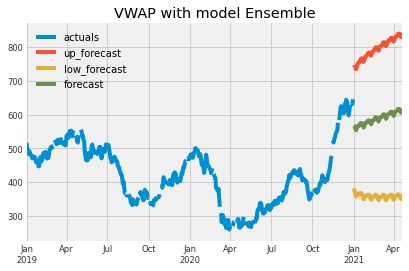

In [14]:
prediction = model.predict()  # generate prediction
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")  # plot a sample

In [15]:
# Print the details of the best model
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'horizontal', 'models': {'7ac5ec7d697c6f9c78c55ec5fe1d653b': {'Model': 'GLM', 'ModelParameters': '{"family": "Poisson", "constant": true, "regression_type": null}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "SeasonalDifference", "1": "bkfilter", "2": "SeasonalDifference", "3": "SeasonalDifference"}, "transformation_params": {"0": {"lag_1": 12, "method": "LastValue"}, "1": {}, "2": {"lag_1": 7, "method": "Median"}, "3": {"lag_1": 7, "method": "Median"}}}'}, 'cbde7f68586b4b749ab56fcb9f70ee4d': {'Model': 'ETS', 'ModelParameters': '{"damped_trend": false, "trend": "additive", "seasonal": null, "seasonal_periods": null}', 'TransformationParameters': '{"fillna": "mean", "transformations": {"0": "Detrend", "1": "Slice"}, "transformation_params": {"0": {"model": "Linear", "phi": 1, "window": null}, "1": {"method": 0.5}}}'}, '3feb0288ca99f818b082fea8329

In [16]:
# point forecasts 
forecasts_df = prediction.forecast

# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

In [17]:
# quality of all tried model results
model_results = model.results()
model_results.head(3)

,ID,Model,ModelParameters,TransformationParameters,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Ensemble,Exceptions,...,mle_weighted,imle_weighted,spl_weighted,containment_weighted,contour_weighted,maxe_weighted,oda_weighted,mqae_weighted,TotalRuntimeSeconds,Score
0,fc88eb52260a48e4849caa581f4a956a,ETS,"{""damped_trend"": false, ""trend"": ""additive"", ""...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.002231,0 days 00:00:00.000016,0 days 00:00:00.233057,0 days 00:00:00.237920,0,NaN,...,62.52113,23.052976,9.825531,0.949367,0.670886,187.218500,0.56962,70.026995,1,26.336980
1,14b3db37578d8ef10cd944886e631dfc,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""rolling_mean"", ""transformations"": ...",0 days 00:00:00.004528,0 days 00:00:00.000016,0 days 00:00:00.172102,0 days 00:00:00.179355,0,NaN,...,82.34597,13.214384,9.097852,0.949367,0.443038,234.253171,0.56962,75.823881,1,27.812783
2,f9165705030a1b5defa914d3f8ab7945,GLM,"{""family"": ""Binomial"", ""constant"": false, ""reg...","{""fillna"": ""ffill_mean_biased"", ""transformatio...",0 days 00:00:00,0 days 00:00:00.017887,0 days 00:00:00,0 days 00:00:00.017887,0,"TypeError(""ufunc 'isfinite' not supported for ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [18]:
# performance
my_rmse(forecasts_df, df_test.VWAP)

186.9652

# `AutoTS` summary:
* minimalistic setup - but tinkering possible
* cornucopia of (univariate) models
* GA is **slow**
* very much beta version

<a id="section-two"></a>

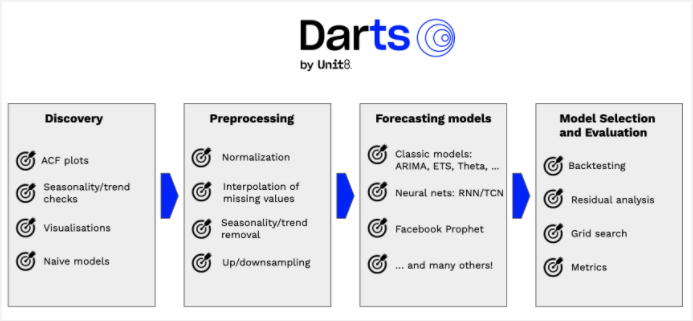

<a id="section-three"></a>
# Kats

Facebook Research unit made its first appearance in this series thanks to Prophet, but it is far from their only contribution to time series - recently they released their own one-stop-shop in the form of `Kats`: https://facebookresearch.github.io/Kats/. The elevator pitch for `Kats` contains it with  generic analysis, forecasting, anomaly detection, multivariate analysis, and feature extraction/embedding. An interesting feature is that it incorporates both vintage methods like ARIMA and modern ones (based on LSTM). 


Kats implements an ensembling solution just like `darts` (choosing an implementation is a YMMV type of situation), but their take on backtesting has useful metrics info not available - at least not so easily - in darts.

In [ ]:
# !pip install llvmlite --ignore-installed

In [ ]:
# !pip install kats

In [ ]:
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.arima import ARIMAModel, ARIMAParams

from kats.utils.backtesters import BackTesterSimple


In [ ]:
# stock_name = 'AXISBANK'
df = pd.read_csv('data/nifty50-stock-market-data/{stock_name}.csv', usecols = ['Date', 'VWAP'])
# df = df.loc[df.Date > CFG.cutoff]
# NAs strike again :-( 

# df.set_index("Date").VWAP.plot()
# df = pd.read_csv(CFG.data_folder + 'energy_daily.csv')
df['y'] = df['y'] / 10**4
df.set_index("ds").y.plot()


In [ ]:
# prepare into Kats format
from kats.consts import TimeSeriesData
df.columns = ["time", "value"]
df['time'] = pd.to_datetime(df['time'])
df_ts = TimeSeriesData(df, time_col_name="time")

In [ ]:
backtester_errors = {}

# specify the metrics we are interested in
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv

In [ ]:
air_passengers_df = pd.read_csv("air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)


ARIMA model:

In [ ]:

params = ARIMAParams(p=2, d=1, q=1)

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data= df_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

In [ ]:
# store the errors in the dictionary
backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

Prophet:

In [ ]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()



In [ ]:
backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

Exponential smoothing:


In [ ]:
params_hw = HoltWintersParams(trend = 'additive') # additive mode gives worse results

backtester_hw = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_hw,
    train_percentage=75,
    test_percentage=25, 
    model_class=HoltWintersModel)

backtester_hw.run_backtest()


In [ ]:
backtester_errors['hw'] = {}
for error, value in backtester_hw.errors.items():
    backtester_errors['hw'][error] = value

Combine the results:


In [ ]:
pd.DataFrame.from_dict(backtester_errors)

`Kats` takeaway:
* multiple models - statistics, DL, hybrid (but fewer than darts)
* backstesting - more metrics
* ensembling 
* global model!


Don't say goodbye to `darts` and `Kats` just yet - we will meet them in again, in the episode dedicated to meta learning and transfer learning for time series. 

<a id="section-four"></a>
# Bonus track: GluonTS

For some inexplicable reason, `GluonTS` escaped my attention when I was writing this episode - but if a rock band can release a new version of an album with extra material, so can I :-) GluonTS is a library for probabilistic time series modeling, focusing on deep learning; while there are numerous libraries utilizing DL (including some desribed above), it's the probabilistic part that makes Gluon truly stand out (well, and the fact they are one of a few environments left that keep the torch burning for `MXNet`). In this section, we will take Gluon for a test drive.

In [ ]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

`GluonTS` comes with several DL models - full list of references (including source papers) is available in the official documentation https://github.com/awslabs/gluon-ts:

- DeepAR
- DeepState
- DeepFactor
- Deep Renewal Processes
- GPForecaster
- MQ-CNN
- MQ-RNN
- N-BEATS
- Rotbaum
- Causal Convolutional Transformer
- Temporal Fusion Transformer
- Transformer
- WaveNet
- SimpleFeedForward
- DeepVAR
- GPVAR
- LSTNet
- DeepTPP
- RForecast
- Prophet
- NaiveSeasonal
- Naive2
- NPTS



We will demonstrate Gluon capabilities by using DeepAR: an algorithm developed by Amazon Research that builds probabilistic forecasts for multiple time series using LSTM architecture as a basis (see the RNN episode for a refresher on LSTM https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends). TL;DR summary of the Amazon twist is that encoder and decoder networks share the same architecture:

[source](https://towardsdatascience.com/prophet-vs-deepar-forecasting-food-demand-2fdebfb8d282)

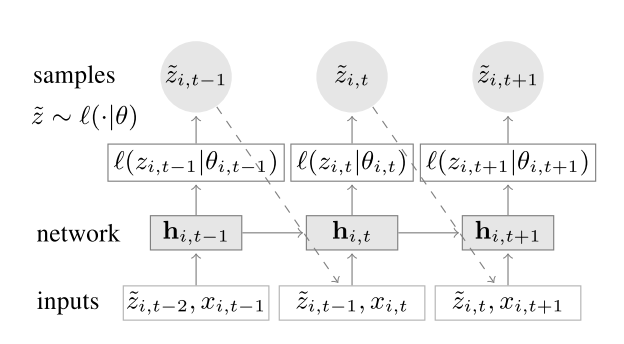

Main features of Deep AR:

- incorporation of covariates 

- a categorical variables specifying grouping of the related time series (models train an embedding vector that learns the common properties of all the time series in the group)

- automatic creation of additional feature time series, depending on the granularity of the target time series (e.g. indicators for day of week, month of year etc)

- MC sampling for distibutional properties inference 

- **Built-in item supersession**: It can predict on items with little history items by learning from similar items

We will use [dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) on hourly energy consumption from across different regions in the US - due to regional variation, the patterns can differ substantially $\implies$ a single model handling them jointly has potential business value.


In [ ]:
# setup the data and align the lengths for simplicity

df1 = pd.read_csv("../input/hourly-energy-consumption/COMED_hourly.csv",parse_dates = True)
df1 = df1.loc[df1["Datetime"] > '2011-12-31'].reset_index(drop = True)
df2 = pd.read_csv("../input/hourly-energy-consumption/DOM_hourly.csv",parse_dates = True)
df2 = df2.loc[df2["Datetime"] > '2011-12-31'].reset_index(drop = True)
df3 = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv",parse_dates = True)
df3 = df3.loc[df3["Datetime"] > '2011-12-31'].reset_index(drop = True)


# (minor) DeepAR kink: convert everything long -> wide
def format_df(df):
    xname = df.columns[1][:-3]
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df['Station_Name'] = xname
    df = df.reset_index(drop = True)

    return df


df1 = format_df(df1)
df2 = format_df(df2)
df3 = format_df(df3)


# combine
df_all = pd.concat([df1 , df2, df3] , axis = 0 )
df_all = df_all.set_index("Station_Name")
df_all = df_all.reset_index()


# grouping variable for using with DeepAR
ts_code=df_all['Station_Name'].astype('category').cat.codes.values
ts_code

In [ ]:
# train / test split
freq="1H"
start_train = pd.Timestamp("2011-12-31 01:00:00", freq=freq) 
start_test = pd.Timestamp("2016-06-10 18:00:00", freq=freq) 

prediction_lentgh= 24 * 1 

df_train=df_all.iloc[:,1:40000].values
df_test=df_all.iloc[:,40000:].values

Just like every other library discussed in this notebook, `GluonTS` has its own class for handling time series datasets:

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_train,
                             ts_code.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_test,
                            ts_code.reshape(-1,1))
], freq=freq)

After this (admittedly slightly longer than in previous cases ;-) preparation work, we can define our model - we give explanation for the DeepAR-specific parameters, as the rest is fairly standard for RNN / LSTM modeling:

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq=freq, 
                            context_length=24 * 5, 
                            prediction_length = prediction_lentgh,
                            # indicator variable to tell our model which time series observation is which
                            # see ts_code above                                                                
                            use_feat_static_cat=True,
                            # While making predictions we are only using the returns observation for each item month wise and no other extra features , 
                            # hence cardinality of 1
                            cardinality=[1],
                            num_layers=2,
                            num_cells=32,
                            cell_type='lstm',
                            dropout_rate = 0.25,
                            trainer=Trainer(epochs= 10 , learning_rate=1e-3  ,batch_size = 512, patience = 5 ))

Training the model is not a challenge to anybody familiar with the `scikit-learn` way of doing things:

In [ ]:
predictor = estimator.train(training_data=train_ds)


Generating predictions works in a manner slightly similar to Prophet: we need to generate MC samples to get at confidence intervals

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=100, 
)


from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(df_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(df_test)))

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
for i in tqdm(range(3)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

In [ ]:
agg_metrics

In [ ]:
item_metrics